In [1]:
%load_ext autoreload
# to make modification in .py file type %autoreload

%load_ext line_profiler
#for finding out how long code takes to run
#an example of how to get diagnostics on functions
#%lprun -f ff.generate_map_full ff.generate_map_full(384, A_BB, alpha_BB, beta_sigma, freqs, nu0)

In [2]:
#trying to consolidate the work so far into a cohesive document and notation. Pushing definitions into 
#separate .py file

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize




Populating the interactive namespace from numpy and matplotlib


In [7]:
%autoreload

# Parameters used for generating map

In [16]:
nside = 128
amp = 1.7e3
alpha = -3.0
beta = -3.2
gamma = -2.5
ells = np.arange(3*nside)
freqs = np.linspace(30, 300, 5)*1.e9

# Generate model using input parameters for comparison

In [10]:
start=time.time()
model = ff.model(freqs, amp, alpha, beta, gamma)
print(time.time()-start)

1.5038988590240479


# Define a residual function to be minimized
(should really normalise by cosmic variance or something)

In [11]:
def residuals(params, freqs, data):
    amp, alpha, beta, gamma = params
    model = ff.model(freqs, amp, alpha, beta, gamma)
    return np.sum((data - model)**2)

# Generate PS data

In [13]:
power_spectrum_data = ff.PS_data(freqs, amp, alpha, beta, gamma)

# Try minimizing

In [127]:
start=time.time()
result = minimize(residuals, [1e3, -1, -1, -3], args=(freqs, power_spectrum_data), bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

207.48961782455444


In [129]:
result

      fun: 1.5267280881389482e+22
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-9.25766848e+22, -2.94237166e+23,  3.61428450e+22, -6.82660067e+23])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 130
      nit: 3
   status: 0
  success: True
        x: array([1000.00000159,   -1.00000033,   -1.00000141,   -3.00000065])

# not really moving from initialising position....

In [29]:
%autoreload

# On 1d data (single frequency spectrum) try doing a curve_fit

In [33]:
model_single = ff.model_single(ells, amp, alpha, beta, gamma)

In [24]:
model_single.shape

(384,)

In [34]:
data_single = ff.PS_data(30e9, amp, alpha, beta, gamma)

In [77]:
start=time.time()
opt_params, covariance = curve_fit(ff.model_single, ells, data_single, p0=[1e3, -1, -1, -3], bounds=(-np.inf,[np.inf,np.inf,np.inf,-2.001]))
print(time.time()-start)

41.09994316101074


In [78]:
opt_params

array([1000.00002695,   -1.03346684,   -1.05901874,   -3.00724813])

# not really moving from initialising position....

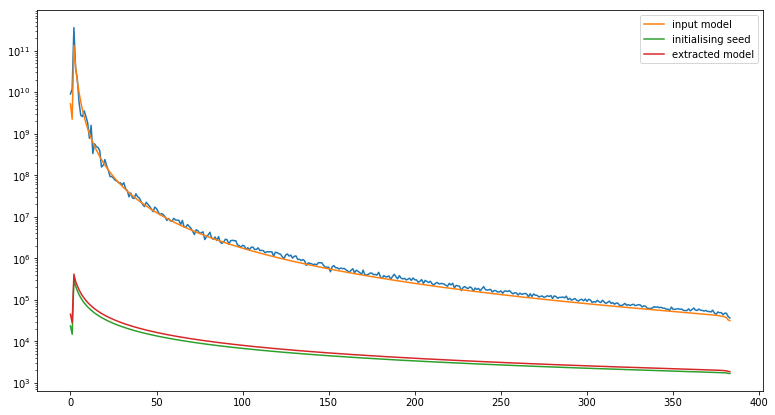

In [79]:
figure(figsize(13,7))
semilogy(data_single)
semilogy(model_single, label='input model')
semilogy(ff.model_single(ells, 1e3, -1, -1, -3), label='initialising seed')
semilogy(ff.model_single(ells, opt_params[0], opt_params[1], opt_params[2], opt_params[3]), label='extracted model')
legend()

# not great...

# Try minimising with a function that calcs. all moments at same time, and with cosmic variance considered

In [86]:
full_model = ff.full_model(ells, freqs, amp, alpha, beta, gamma)

In [85]:
%autoreload

In [87]:
full_model.shape

(5, 384)

In [182]:
#try residual stuff with this new 'full_model' function
def residuals_full(params, ells, freqs, data):
    chi2 = 0
    amp, alpha, beta, gamma = params
    model = ff.full_model(ells, freqs, amp, alpha, beta, gamma)
    
    #set up array of 2/(2*ell+1) then multiply by C_ell^2
    var = np.zeros((len(freqs),len(ells)))
    for ell in range(len(ells)):
        var[:,ell] = 2/(2*ell+1)
    cosmic_var = var * model**2
    chi2 = (data[2:] - model[2:])**2 / cosmic_var[2:]
#     print(chi2)
    return np.sum(chi2)

In [165]:
parameters = [amp, alpha, beta, gamma]

In [117]:
power_spectrum_data[:,2:].shape

(5, 382)

In [183]:
x = residuals_full(parameters, ells, freqs, power_spectrum_data)
print(x)

1700.0285005909254


In [160]:
start=time.time()
result = minimize(residuals_full, [1e3, -1, -1, -3], args=(ells, freqs, power_spectrum_data), bounds=((None, None), (None, None), (None, None), (None, -2.01)))
print(time.time()-start)

320.72851610183716


In [161]:
result

      fun: 260053094631.77448
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.91270175e+17, -5.87128886e+18, -9.83908182e+18,  2.61885067e+19])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 195
      nit: 4
   status: 0
  success: True
        x: array([1000.00000015,   -1.00000063,   -1.00000034,   -3.00000062])

# So good news is that the variation in chi^2 is only order 1-10 now, bad news is that minimize still doesn't move us away from initialization...

In [195]:
big_x = np.zeros(100)
for i in range(100):
    big_x[i] = residuals_full(parameters, ells, freqs, power_spectrum_data)

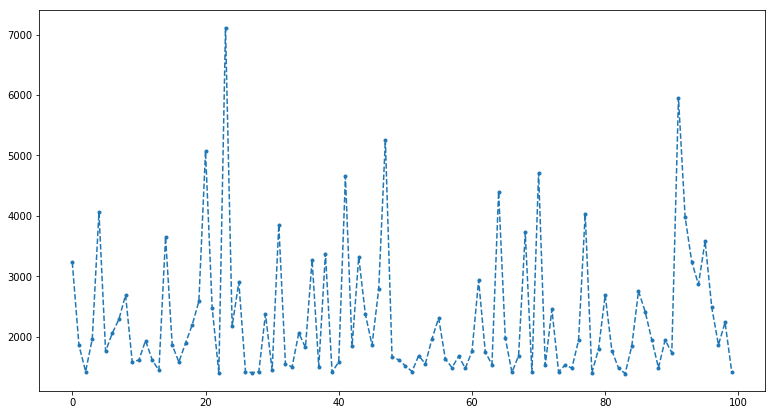

In [196]:
plot(big_x, '--.')

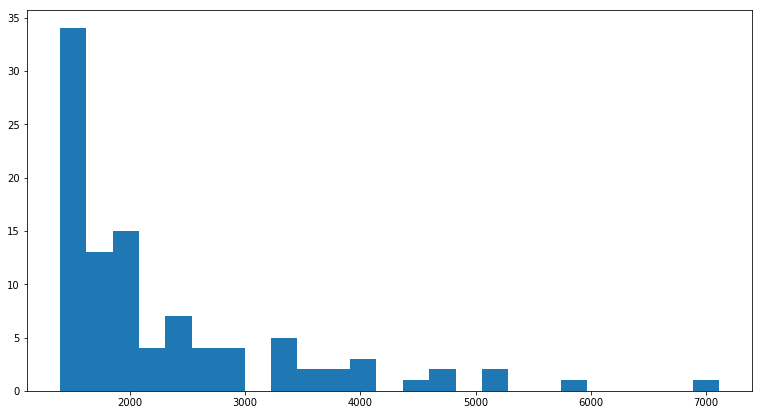

In [197]:
hist(big_x, bins=25);

# unrelated: is there a relation between the standard deviation of the $\beta$ map and the value of $\gamma$ that we can use to lift the realisation dependence of the model through the amplitude?

In [237]:
gammas = np.linspace(-4,-2.01, 100)
std = np.zeros_like(gammas)
std_big = np.zeros((100,100))

In [238]:
start=time.time()
for j in range(100):
    for i in range(len(gammas)):
        bcls = ff.powerlaw(ells, 1, gammas[i])
        beta_map = hp.synfast(bcls, nside, new=True, verbose=False)
        std[i] = np.std(beta_map)
    std_big[j] = std
print(time.time()-start)

364.2304811477661


In [239]:
std_big[0].shape
mean = np.mean(std_big,0)

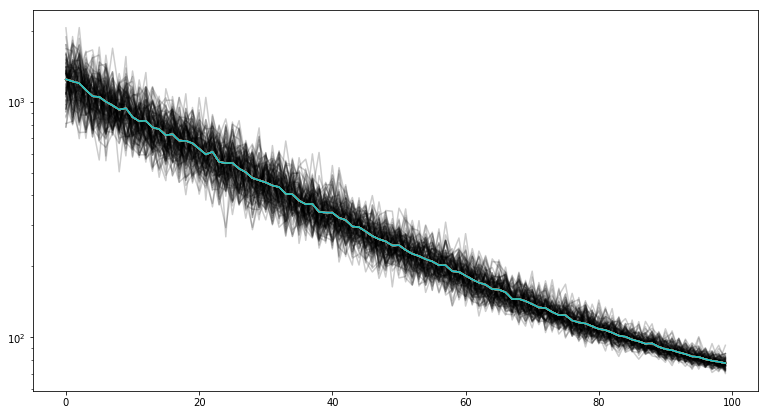

In [240]:
for i in range(100):
    semilogy(std_big[i], 'k', alpha=0.2)
    semilogy(mean)

Text(0, 0.5, 'std of beta map')

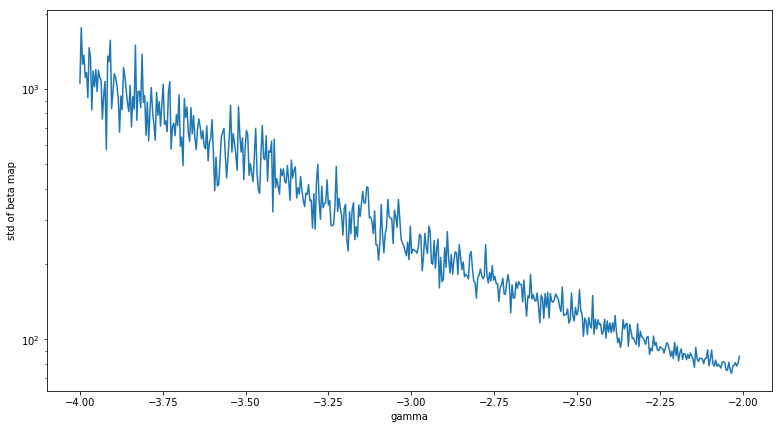

In [212]:
semilogy(gammas, std)
xlabel('gamma')
ylabel('std of beta map')

In [241]:
param, cov = curve_fit(lambda t,a,b: a*numpy.exp(b*t),  gammas,  mean)

In [242]:
a = param[0]
b = param[1]

Text(0, 0.5, 'std of beta map')

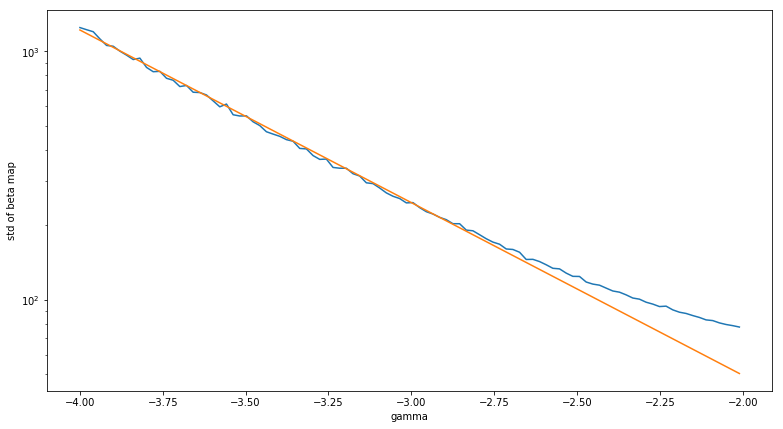

In [243]:
semilogy(gammas, mean)
semilogy(gammas, a*np.exp(b*gammas))
xlabel('gamma')
ylabel('std of beta map')